In [3]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr  3 22:45:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [20]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 32  # Reduced initial channels

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 32, layers[0])  # Adjusted channels
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)  # Adjusted channels
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)  # Adjusted channels
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)  # Adjusted channels

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)  # Adjusted to match reduced channels

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18_modified(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
       BasicBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,

In [25]:
#training (verbose) on CIFAR10
import time

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    device = next(model.parameters()).device

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        start_time = time.time()
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total

        model.eval()  # eval
        with torch.no_grad():
            total = 0
            correct = 0
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        elapsed_time = time.time() - start_time

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Accuracy: {train_acc:.2f}%, '
              f'Test Accuracy: {test_acc:.2f}%, '
              f'Time: {elapsed_time:.2f}s')

# Usage
num_epochs = 10
model = resnet18_modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10, Train Loss: 1.3952, Train Accuracy: 48.66%, Test Accuracy: 52.09%, Time: 28.29s
Epoch 2/10, Train Loss: 0.9405, Train Accuracy: 66.43%, Test Accuracy: 70.27%, Time: 30.34s
Epoch 3/10, Train Loss: 0.7443, Train Accuracy: 73.97%, Test Accuracy: 74.26%, Time: 29.06s
Epoch 4/10, Train Loss: 0.6301, Train Accuracy: 78.04%, Test Accuracy: 77.99%, Time: 32.03s
Epoch 5/10, Train Loss: 0.5577, Train Accuracy: 80.42%, Test Accuracy: 79.76%, Time: 29.06s
Epoch 6/10, Train Loss: 0.5014, Train Accuracy: 82.58%, Test Accuracy: 79.60%, Time: 28.60s
Epoch 7/10, Train Loss: 0.4611, Train Accuracy: 84.12%, Test Accuracy: 84.25%, Time: 27.78s
Epoch 8/10, Train Loss: 0.4209, Train Accuracy: 85.47%, Test Accuracy: 81.86%, Time: 28.82s
Epoch 9/10, Train Loss: 0.3910, Train Accuracy: 86.36%, Test Accuracy: 82.89%, Time: 32.72s
Epoch 10/10, Train Loss: 0.3654, Train Accuracy: 87.43%, Test Accuracy: 84.88%, Time: 29.82s


In [26]:
import pickle

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

unpickle('./cifar_test_nolabels.pkl')

{b'data': array([[133, 136, 136, ..., 226, 225, 224],
        [160, 177, 176, ...,  89,  89,  88],
        [255, 255, 255, ..., 211, 213, 215],
        ...,
        [ 29,  29,  45, ..., 156, 155, 154],
        [124, 123, 126, ...,  49,  49,  51],
        [255, 255, 255, ..., 250, 251, 255]], dtype=uint8),
 b'ids': array([   0,    1,    2, ..., 9997, 9998, 9999])}

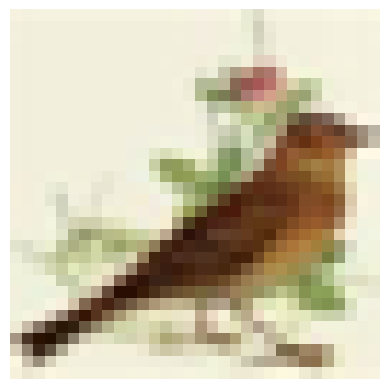

In [27]:
#sanitycheck, CIFAR nolabel data is loading
import numpy as np
import matplotlib.pyplot as plt

data = unpickle('./cifar_test_nolabels.pkl')
image_id = 1111 #change this to look at the image by id (goes 0 thru 9999)

an_image = data[b'data'][image_id]
an_image = an_image.reshape(3, 32, 32)
an_image = an_image.transpose(1, 2, 0)

plt.imshow(an_image)
plt.axis('off')
plt.show()

In [28]:
# Load and preprocess the unlabeled data
images = torch.tensor(data[b'data']).float()
images = images.view(-1, 3, 32, 32)
images = images / 255.0

# Normalize images as done during training
images = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(images)

In [29]:
import pandas as pd

# Predict
model.eval()
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Save predictions to CSV
predictions = predicted.cpu().numpy()
ids = np.arange(len(predictions))
submission = pd.DataFrame({'ID': ids, 'Label': predictions})
submission.to_csv('cifar_predictions.csv', index=False)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18_modified(num_classes=10):
    return CustomResNet(BasicBlock, [3, 3, 3], num_classes=num_classes)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
# Normalize the images
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

images = torch.tensor(images)
images = transform(images)

# Since we don't have labels, using dummy labels for demonstration
labels = torch.zeros(images.size(0), dtype=torch.long)

# Create the DataLoader
dataset = TensorDataset(images, labels)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model, Loss, and Optimizer
model = resnet18_modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, _) in enumerate(loader):
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.to(device))  # Using dummy labels here
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')